In [225]:
!pip install bitarray

#Nén dữ liệu

Các bước thực hiện:
1. Đọc ảnh theo dạng ycbcr, chia thành các khối 8x8.
2. DCT transform
3. Quantization transform
4. RCL transform và Huffman transform

Khai báo thư viện

In [226]:
import matplotlib
import cv2
import collections
import math
import string
import os
import numpy as np
import time
from math import log
from matplotlib import pyplot as plt
from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim
from collections import Counter
from heapq import heappush, heappop, heapify
import bitarray
from google.colab.patches import cv2_imshow

In [227]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [228]:
!gdown 'https://www.reasoft.com/tutorials/web/img/plast01.jpg'

Downloading...
From: https://www.reasoft.com/tutorials/web/img/plast01.jpg
To: /content/plast01.jpg
100% 54.1k/54.1k [00:00<00:00, 5.41MB/s]


Đọc ảnh theo dạng ycbcr, chia thành các khối 2x2 để thực hiện chrominance conversion.

In [229]:
#Read image
# image = cv2.imread('/content/drive/MyDrive/example.jpg')
image = cv2.imread('plast01.jpg')
#Choose quantizated rate for quantization transform (high rate means good quality)
quantizated_rate = 90 #(0% - 100%)



ycbcr_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
Y, Cb, Cr = cv2.split(ycbcr_image)

height, width = image.shape[:2]
#Chrominance conversion

def Chrominance_conversion(array, height, width):
    blocks=[]
    for y in range(0, height, 2):
      a=[]
      for x in range(0, width, 2):
        block = array[y:y+2, x:x+2]
        a.append(block)
      blocks.append(a)

    mean_blocks = []
    for block in blocks:
      a=[]
      for i in block:
        avg = np.mean(i)
        a.append(avg)
      mean_blocks.append(a)
    return mean_blocks

new_Y = np.array(Y)
mean_Cb = Chrominance_conversion(Cb, height, width)
mean_Cr = Chrominance_conversion(Cr, height, width)

#resize:
mean_Cb = np.array(mean_Cb)
mean_Cr = np.array(mean_Cr)

new_Cb = cv2.resize(mean_Cb, (width, height))
new_Cr = cv2.resize(mean_Cr, (width, height))


Merge ảnh lại kiểm tra xem các bước đọc ảnh đúng không

In [230]:
# #merge
new_Cb = new_Cb.astype(np.uint8)
new_Cr = new_Cr.astype(np.uint8)
merged_image = cv2.merge([new_Y, new_Cb, new_Cr])
merged_image = cv2.cvtColor(merged_image, cv2.COLOR_YCrCb2BGR)

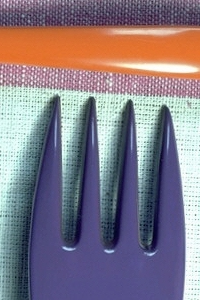

-1

In [231]:
#Image after Chrominance conversion
cv2_imshow(merged_image)
cv2.waitKey(0)

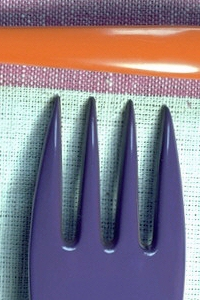

-1

In [232]:
cv2_imshow(image)
cv2.waitKey(0)

Chia dữ liệu thành block 8x8 để thực hiện DCT và quantization

In [233]:
#split 2D array to blocks 8x8
def split2dto8x8(array, height, width):
    blocks = []
    num_blocks_x = width // 8
    num_blocks_y = height // 8
    for y in range(num_blocks_y):
      for x in range(num_blocks_x):
          block = array[y*8:(y+1)*8, x*8:(x+1)*8]
          blocks.append(block)
    return blocks

blocks_Y = split2dto8x8(new_Y, height, width)
blocks_Cb = split2dto8x8(new_Cb, height, width)
blocks_Cr = split2dto8x8(new_Cr, height, width)


note: 925 blocks,64 pixels for each blocks, represent as 8x8 block

Áp dụng thuật toán DCT

In [234]:
#DCT transform
def dct_transform(array):
    dct_blocks = []
    for block in array:
      dct_block = cv2.dct(block.astype(np.float32))
      dct_blocks.append(dct_block)
    return dct_blocks

dct_blocks_Y = dct_transform(blocks_Y)
dct_blocks_Cb = dct_transform(blocks_Cb)
dct_blocks_Cr = dct_transform(blocks_Cr)

Thực hiện kĩ thuật Quantization transform

In [235]:
# Quantization table for quantizated transform

quantization_table_Y = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                [12, 12, 14, 19, 26, 58, 60, 55],
                                [14, 13, 16, 24, 40, 57, 69, 56],
                                [14, 17, 22, 29, 51, 87, 80, 62],
                                [18, 22, 37, 56, 68, 109, 103, 77],
                                [24, 35, 55, 64, 81, 104, 113, 92],
                                [49, 64, 78, 87, 103, 121, 120, 101],
                                [72, 92, 95, 98, 112, 100, 103, 99]])

quantization_table_C = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                                [18, 21, 26, 66, 99, 99, 99, 99],
                                [24, 26, 56, 99, 99, 99, 99, 99],
                                [47, 66, 99, 99, 99, 99, 99, 99],
                                [99, 99, 99, 99, 99, 99, 99, 99],
                                [99, 99, 99, 99, 99, 99, 99, 99],
                                [99, 99, 99, 99, 99, 99, 99, 99],
                                [99, 99, 99, 99, 99, 99, 99, 99]])

quantization_table_Y = [[int(value * (2 - np.round(quantizated_rate/100))) for value in row] for row in quantization_table_Y]
quantization_table_C = [[int(value * (2 - np.round(quantizated_rate/100))) for value in row] for row in quantization_table_C]

#Quantizated transform
def quantizated_transform(array, quantization_table):
    quantized_blocks = []
    for dct_block in array:
      quantized_block = np.round(dct_block / quantization_table)
      quantized_blocks.append(quantized_block)
    return quantized_blocks

quantized_blocks_Y = quantizated_transform(dct_blocks_Y, quantization_table_Y)
quantized_blocks_Cb = quantizated_transform(dct_blocks_Cb, quantization_table_C)
quantized_blocks_Cr = quantizated_transform(dct_blocks_Cr, quantization_table_C)


Chuyển từ các block 8x8 thành list 1D (nhẹ hơn khi lưu dữ liệu)

In [236]:
#Flatten array to make it easy to save
def flatten(array):
    flat = []
    for blocks in array:
      for block in blocks:
        for i in block:
            flat.append(i)
    return flat

flatten_Y = flatten(quantized_blocks_Y)
flatten_Cb = flatten(quantized_blocks_Cb)
flatten_Cr = flatten(quantized_blocks_Cr)

Áp dụng thuật toán nén RLC

In [237]:
#Run-Length Coding transform (RLC)

def rlc_transform(array):
    rlc = []
    prev_coeff = None
    count = 0
    for coeff in array:
        if coeff == prev_coeff:
            count += 1
        else:
            if prev_coeff is not None:
                rlc.append((prev_coeff, count))
            prev_coeff = coeff
            count = 1
    rlc.append((prev_coeff, count))
    return rlc

rlc_Y = rlc_transform(flatten_Y)
rlc_Cb = rlc_transform(flatten_Cb)
rlc_Cr = rlc_transform(flatten_Cr)

Áp dụng thuật toán nén Huffman

In [238]:
#Huffman
def huffman_transform(array):
    # Step 1: Generate frequency counts for each symbol in RLE blocks
    freq = Counter()
    freq.update(array)
    # Step 2: Build Huffman tree based on frequency counts
    heap = [[weight, [symbol, ""]] for symbol, weight in freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

    # Step 3: Get Huffman codes from the Huffman tree
    huffman_codes = {}
    for pair in heap[0][1:]:
        huffman_codes[pair[0]] = pair[1]

    # Step 4: Encode RLE blocks using Huffman codes
    encoded = []

    for i in array:
        encoded_block = bitarray.bitarray(huffman_codes[i])
        encoded.append(encoded_block)

    return encoded, huffman_codes

encoded_Y, huffman_codes_Y = huffman_transform(rlc_Y)
encoded_Cb, huffman_codes_Cb = huffman_transform(rlc_Cb)
encoded_Cr, huffman_codes_Cr = huffman_transform(rlc_Cr)

In [239]:
# # Vậy là đã có được các blocks mã hóa, ta chỉ việc lưu lại
import pickle
image_size = (width, height)

data = {
    'image_size': image_size,
    'quantization_table_Y': quantization_table_Y,
    'quantization_table_C': quantization_table_C,
    'huffman_codes_Y': huffman_codes_Y,
    'huffman_codes_Cb': huffman_codes_Cb,
    'huffman_codes_Cr': huffman_codes_Cr,
    'encoded_blocks_Y': encoded_Y,
    'encoded_blocks_Cb': encoded_Cb,
    'encoded_blocks_Cr': encoded_Cr
}

filename = 'compressed_data.pkl'
with open(filename, 'wb') as file:
    pickle.dump(data, file)

In [240]:
#Đọc file data
with open(filename, 'rb') as file:
    data = pickle.load(file)

In [241]:
width, height = data['image_size']
quantization_table_Y = data['quantization_table_Y']
quantization_table_C = data['quantization_table_C']
huffman_codes_Y = data['huffman_codes_Y']
huffman_codes_Cb = data['huffman_codes_Cb']
huffman_codes_Cr = data['huffman_codes_Cr']
encoded_blocks_Y = data['encoded_blocks_Y']
encoded_blocks_Cb = data['encoded_blocks_Cb']
encoded_blocks_Cr = data['encoded_blocks_Cr']

#Giải nén dữ liệu

Các bước thực hiện (ngược lại của bước nén dữ liệu):
1. Giải nén từ huffman code thành rlc list
2. Từ RLC list biến đổi thành quantizated list (1 chiều)
3. Biến đổi từ list 1 chiều thành các block 8x8 rồi biến đổi ngược kĩ thuật quantization transform và DCT transform
4. Biến đổi các block 8x8 thành mảng 2D để merge lại thành ảnh


In [242]:
#From encoded_huffman, decode into rlc list
def decode_huffman(bit_array, huffman_codes):
    decoded_rlc = []
    for i in bit_array:
      code = bitarray.bitarray()
      for bit in i:
          code.append(bit)
          if code.to01() in huffman_codes.values():
              symbol = {j for j in huffman_codes if huffman_codes[j]==code.to01()}
              decoded_rlc.append(list(symbol)[0])
              code = bitarray.bitarray()
    return decoded_rlc

decoded_rlc_Y = decode_huffman(encoded_Y,huffman_codes_Y)
decoded_rlc_Cb = decode_huffman(encoded_Cb, huffman_codes_Cb)
decoded_rlc_Cr = decode_huffman(encoded_Cr, huffman_codes_Cr)


In [243]:
#From RLC list, decode into quantized array
def dedcode_rlc(array):
    decoded_quantized = []
    for symbol, count in array:
      decoded_quantized.extend([symbol] * count)

    decoded_quantized = np.array(decoded_quantized)
    return decoded_quantized

decoded_quantized_Y = dedcode_rlc(decoded_rlc_Y)
decoded_quantized_Cb = dedcode_rlc(decoded_rlc_Cb)
decoded_quantized_Cr = dedcode_rlc(decoded_rlc_Cr)

In [244]:
#split 1D array to block 8x8
def split1dto8x8(array):
    decoded_quantized_blocks = []
    num_blocks = len(array) // (8 * 8)
    for i in range(num_blocks):
      block = array[i * 8 * 8 : (i + 1) * 8 * 8]
      block = block.reshape((8, 8))
      decoded_quantized_blocks.append(block)
    return decoded_quantized_blocks

decoded_quantized_blocks_Y = split1dto8x8(decoded_quantized_Y)
decoded_quantized_blocks_Cb = split1dto8x8(decoded_quantized_Cb)
decoded_quantized_blocks_Cr = split1dto8x8(decoded_quantized_Cr)

In [245]:
#quantized decode transform
def decode_quantized_transform(array, quantization_table):
    decoded_dct_blocks = []
    for quantized_block in array:
      dct_block = quantized_block * quantization_table
      decoded_dct_blocks.append(dct_block)
    return decoded_dct_blocks


decoded_dct_blocks_Y = decode_quantized_transform(decoded_quantized_blocks_Y, quantization_table_Y)
decoded_dct_blocks_Cb = decode_quantized_transform(decoded_quantized_blocks_Cb, quantization_table_C)
decoded_dct_blocks_Cr = decode_quantized_transform(decoded_quantized_blocks_Cr, quantization_table_C)

In [246]:
#dct decode transform
def decode_dct_transform(array):
    decoded_blocks = []
    for block in array:
      i = cv2.idct(block.astype(np.float32))
      decoded_blocks.append(i)
    return decoded_blocks

decoded_blocks_Y = decode_dct_transform(decoded_dct_blocks_Y)
decoded_blocks_Cb = decode_dct_transform(decoded_dct_blocks_Cb)
decoded_blocks_Cr = decode_dct_transform(decoded_dct_blocks_Cr)

In [247]:
#merge blocks 8x8 back to 2D image
def merge_img(array, heigth, width):
    image_block = np.zeros((height, width), dtype=np.uint8)
    block_size = 8
    num_blocks_x = width // block_size
    num_blocks_y = height // block_size
    for i, block in enumerate(array):
      y = i // num_blocks_x
      x = i % num_blocks_x
      image_block[y*block_size:(y+1)*block_size, x*block_size:(x+1)*block_size] = block
    return image_block

image_Y = merge_img(decoded_blocks_Y, height, width)
image_Cb = merge_img(decoded_blocks_Cb, height, width)
image_Cr = merge_img(decoded_blocks_Cr, height, width)


In [248]:
final_image = cv2.merge([image_Y, image_Cb, image_Cr])
final_image = cv2.cvtColor(final_image, cv2.COLOR_YCrCb2BGR)

In [249]:
cv2.imwrite('final_image.jpeg', final_image)

True

In [250]:
image_size = os.path.getsize('plast01.jpg')
final_version = os.path.getsize('final_image.jpeg')

In [251]:
mse = ((image.astype(np.float64) - final_image.astype(np.float64)) ** 2).mean(axis=None)

In [252]:
PSNR = 10 * log(((255 * 255) / mse), 10)

In [253]:
compression_ratio = image_size/final_version

In [254]:
print('Quantization rate:', np.round(quantizated_rate), '%')
print("The original image file size:", image_size, "bytes")
print("Image size file after compressed and decompressed:", final_version, "bytes")
print("The reduced size:", image_size-final_version, "bytes")
print('MSE:', mse)
print('PSNR:', PSNR)
print('compression ratio:', compression_ratio)

Quantization rate: 90 %
The original image file size: 54124 bytes
Image size file after compressed and decompressed: 24935 bytes
The reduced size: 29189 bytes
MSE: 628.8638722222222
PSNR: 20.14523715328766
compression ratio: 2.170603569280128


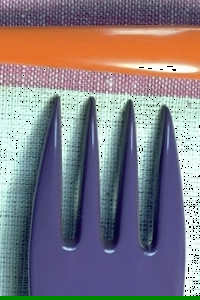

-1

In [255]:
#Final result
cv2_imshow(final_image)
cv2.waitKey(0)

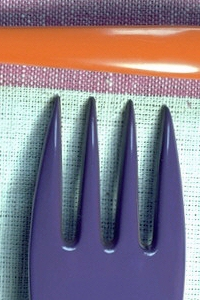

-1

In [256]:
#Origin image
cv2_imshow(image)
cv2.waitKey(0)